In [1]:
from utils import *
#from constants import *
from networks import *

import json
import os
import matplotlib.pyplot as plt
import numpy as np
import utils

Using TensorFlow backend.


In [ ]:
reload(utils)

### Constants

In [14]:
##### constants ######


# PATH definition
initial_weights_path = "./models/initial_weights.hdf5"
final_weights_path = "./models/output_weights_batch_norm.hdf5"

param_path = "./"

# Data definition
# image dimension (array)
img_rows = 512
img_cols = 512


nb_total = 69 # total number of img
nb_train = 53 # number of train img
nb_labeled = 53 # number of labeled image
nb_unlabeled = nb_train - nb_labeled # number of unlabeled images

# CEAL parameters
apply_edt = False
nb_iterations = 1 # number of active iteration

nb_step_predictions = 10

# For sample selection to present to the oracle
nb_no_detections = 1 # number of samples in the histogram area with accuracy = 0 (no detection)
nb_random = 1 # number of randomly selected samples
nb_most_uncertain = 1 # number of samples selected in the most uncertain area (highest uncertainty)
most_uncertain_rate = 1 # threshold to define the most uncertain area. 

# this 2+2+2 samples are presented to oracle for annotation

pseudo_epoch = 5
nb_pseudo_initial = 1
pseudo_rate = 2

initial_train = True
nb_initial_epochs = 80
nb_active_epochs = 2
batch_size = 10
steps_per_epoch = nb_labeled / batch_size

apply_augmentation = True
featurewise_center = False
featurewise_std_normalization= False
rotation_range= 0
horizontal_flip= True
vertical_flip =True
zca_whitening = False
rescale = 0
zoom_range= 0
channel_shift_range = 0.2
width_shift_range = 0.1
height_shift_range = 0.1


learning_rate = 1e-3
decay_rate = learning_rate / nb_initial_epochs

## U Net

In [2]:
K.set_image_dim_ordering('th')  # Theano dimension ordering in this code
smooth = 1.
Dropout.call = call

In [3]:
cd ..

/home/malub_local/activelearningADS


In [4]:
data_path = '../data/'

path_img_train = data_path + 'images_69.npy'
path_mask_train = data_path + 'masks_69.npy'

path_img_valid = data_path + 'images_valid_29.npy'
path_mask_valid = data_path + 'masks_valid_29.npy'


path_img_test = data_path + 'images_test_1.npy'
path_mask_test = data_path + 'masks_test_1.npy'


#log_file = open("log_file_jupyter_myelin.txt", 'a')

In [5]:
X_train, y_train = load_data(path_img_train, path_mask_train, img_rows, img_cols )
print("*************Xtrain.shape***********", y_train.shape)
labeled_index = np.arange(0, nb_labeled)
unlabeled_index = np.arange(nb_labeled, len(X_train))


# CEAL data definition
X_valid, y_valid = load_data(path_img_valid, path_mask_valid, img_rows, img_cols)
print("*************Xvalid.shape***********", X_valid.shape)

# CEAL data definition
X_test, y_test = load_data(path_img_test, path_mask_test, img_rows, img_cols)
print("*************Xtest.shape***********", X_test.shape)



Loading data...

('*************Xtrain.shape***********', (69, 1, 512, 512))

Loading data...

('*************Xvalid.shape***********', (29, 1, 512, 512))

Loading data...

('*************Xtest.shape***********', (1, 1, 512, 512))


In [6]:
X_valid = X_valid[:-2]
y_valid = y_valid[:-2]

X_test = X_valid[-2:]
y_test = y_valid[-2:]


print(X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

((27, 1, 512, 512), (27, 1, 512, 512), (2, 1, 512, 512), (2, 1, 512, 512))


In [15]:
# (1) Initialize model
model = unet_full_bn(dropout=True)
#reset_weights(model)

print(model.summary())

# data augmentation
train_generator = data_generator().flow(X_train[labeled_index], y_train[labeled_index],
                                      batch_size=batch_size, 
                                      shuffle=False)

val_generator = data_generator().flow(X_valid, y_valid,
                                      batch_size=batch_size, 
                                      shuffle=False)

# training
if initial_train:
    model_checkpoint = ModelCheckpoint(initial_weights_path, monitor='loss', save_best_only=True)

    if apply_augmentation:
        timestamp = format(time.strftime('%m%d_%H%M_%S'))
        tensorboard = TensorBoard(log_dir = str("../logs/" + str(timestamp)))
        #save_parameters(timestamp, params)
        
        history = model.fit_generator(train_generator, 
                                      validation_data=val_generator,
                                    epochs=nb_initial_epochs, verbose=1, callbacks=[tensorboard])
        
        model.save(initial_weights_path)
   
    else:
        timestamp = format(time.strftime('%m%d_%H%M_%S'))
        tensorboard = TensorBoard(log_dir = str("../logs/" + str(timestamp)))
        #save_parameters(timestamp, params)
        
        history = model.fit(X_train[labeled_index], y_train[labeled_index], validation_data=(X_valid, y_valid),
                            batch_size=batch_size, 
                            epochs=nb_initial_epochs,
                            verbose=1, shuffle=True, callbacks=[tensorboard])

else:
    model.load_weights(initial_weights_path)
    
print("Saving model...\n")   
model.save(final_weights_path)



# uncertainty computation

weights = final_weights_path
modelUncertain = unet_full_bn(dropout=True)
modelUncertain.load_weights(weights)

uncertain = np.zeros(len(X_test))
accuracy = np.zeros(len(X_test))
uncertain_map = []

print("Computing log predictions ...\n")
predictions = predict(X_test, model)

for i in range(len(X_test)):
    sample = X_test[i].reshape([1, 1, img_rows, img_cols])
    sample_prediction = cv2.threshold(predictions[i], 0.5, 1, cv2.THRESH_BINARY)[1].astype('uint8')
    accuracy[i] = compute_dice_coef(y_train[i][0], sample_prediction)
    uncertain[i] = compute_uncertain(sample, sample_prediction, modelUncertain)
    uncertain_map_i = compute_uncertain_map(sample, sample_prediction, modelUncertain)
    uncertain_map.append(uncertain_map_i)
    
    
uncertain_map_array = np.asarray(uncertain_map)
print(uncertain_map_array.shape)
print("Done")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 1, 512, 512)  0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 32, 512, 512) 320         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 32, 512, 512) 9248        conv2d_96[0][0]                  
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 32, 512, 512) 128         conv2d_97[0][0]                  
__________________________________________________________________________________________________
max_poolin

Epoch 1/80
6/6 [==============================] - 3s 572ms/step - loss: 0.3569 - dice_coef: 0.5292 - val_loss: 2.9215 - val_dice_coef: 0.5050
Epoch 2/80
6/6 [==============================] - 3s 517ms/step - loss: 0.2642 - dice_coef: 0.6318 - val_loss: 0.4126 - val_dice_coef: 0.6420
Epoch 3/80
6/6 [==============================] - 3s 516ms/step - loss: 0.2406 - dice_coef: 0.6627 - val_loss: 2.6460 - val_dice_coef: 0.5623
Epoch 4/80
6/6 [==============================] - 3s 520ms/step - loss: 0.2215 - dice_coef: 0.6656 - val_loss: 0.4652 - val_dice_coef: 0.6640
Epoch 5/80
6/6 [==============================] - 3s 519ms/step - loss: 0.2134 - dice_coef: 0.6620 - val_loss: 0.2433 - val_dice_coef: 0.6569
Epoch 6/80
6/6 [==============================] - 3s 516ms/step - loss: 0.2063 - dice_coef: 0.6550 - val_loss: 0.2176 - val_dice_coef: 0.6402
Epoch 7/80
6/6 [==============================] - 3s 516ms/step - loss: 0.1982 - dice_coef: 0.6668 - val_loss: 0.1995 - val_dice_coef: 0.5880
Epoch 

6/6 [==============================] - 3s 517ms/step - loss: 0.0796 - dice_coef: 0.8443 - val_loss: 0.1656 - val_dice_coef: 0.6788
Epoch 59/80
6/6 [==============================] - 3s 517ms/step - loss: 0.0764 - dice_coef: 0.8511 - val_loss: 0.1555 - val_dice_coef: 0.6432
Epoch 60/80
6/6 [==============================] - 3s 517ms/step - loss: 0.0764 - dice_coef: 0.8524 - val_loss: 0.1710 - val_dice_coef: 0.6684
Epoch 61/80
6/6 [==============================] - 3s 516ms/step - loss: 0.0726 - dice_coef: 0.8544 - val_loss: 0.1600 - val_dice_coef: 0.6347
Epoch 62/80
6/6 [==============================] - 3s 516ms/step - loss: 0.0700 - dice_coef: 0.8646 - val_loss: 0.1666 - val_dice_coef: 0.6719
Epoch 63/80
6/6 [==============================] - 3s 519ms/step - loss: 0.0678 - dice_coef: 0.8697 - val_loss: 0.1684 - val_dice_coef: 0.6868
Epoch 64/80
6/6 [==============================] - 3s 516ms/step - loss: 0.0658 - dice_coef: 0.8709 - val_loss: 0.1634 - val_dice_coef: 0.6528
Epoch 65/80

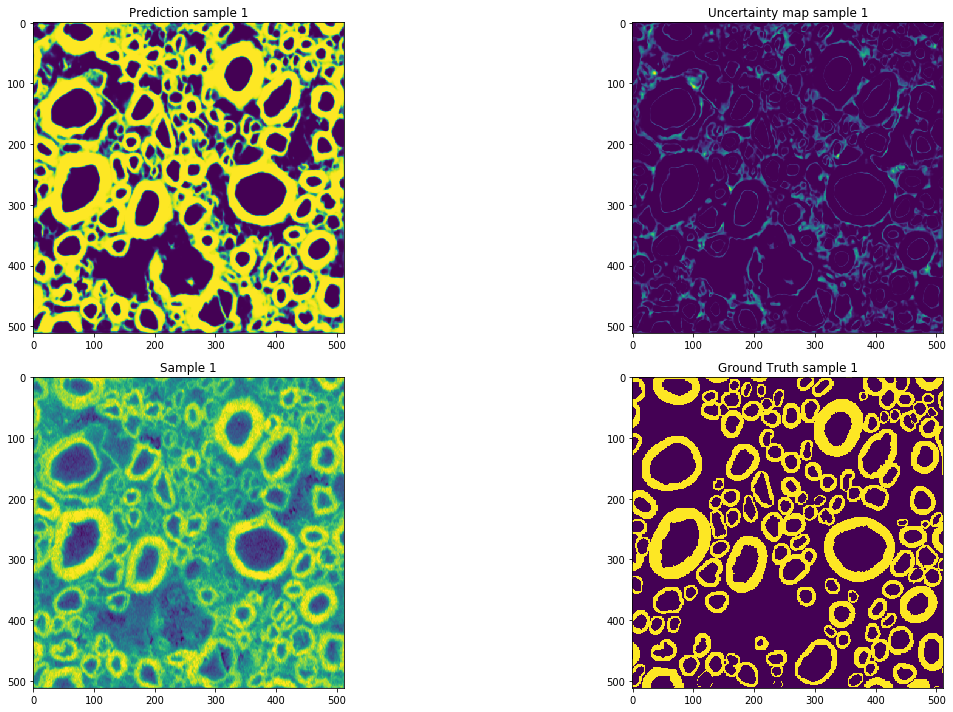

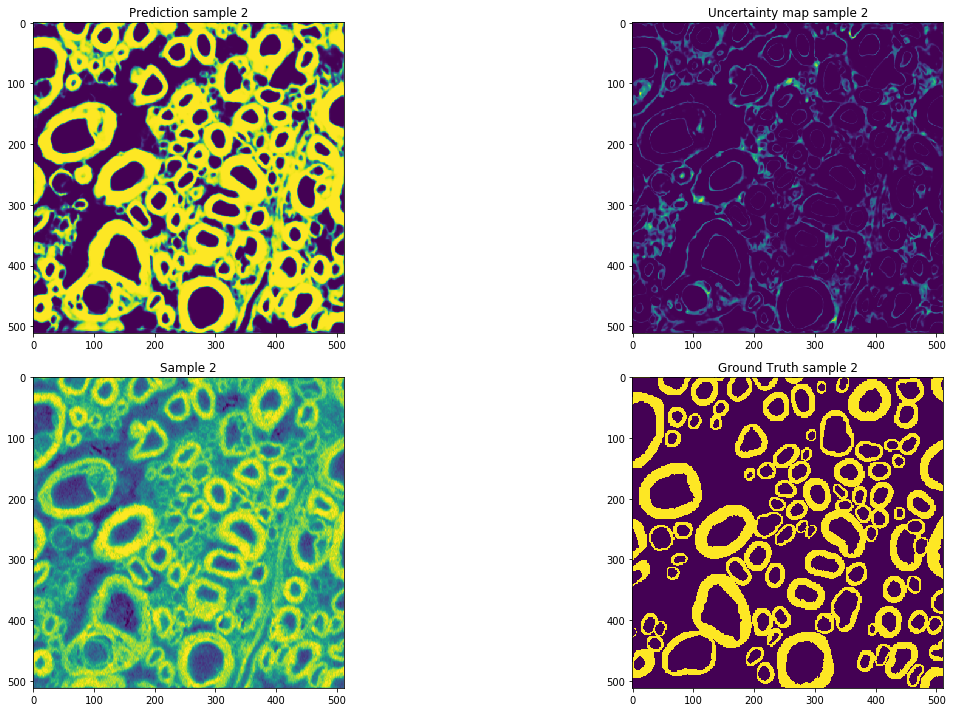

In [11]:
# Plot predictions and uncertainty map for 2 samples 

plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(predictions[0][0,:,:])
plt.title("Prediction sample 1")
plt.subplot(222)
plt.imshow(uncertain_map_array[0])
plt.title("Uncertainty map sample 1")
plt.subplot(223)
plt.imshow(X_test[0][0,:,:])
plt.title("Sample 1")
plt.subplot(224)
plt.imshow(y_test[0][0,:,:])
plt.title("Ground Truth sample 1")
plt.tight_layout()
plt.show()

# Plot predictions and uncertainty map for 2 samples

plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(predictions[1][0,:,:])
plt.title("Prediction sample 2")
plt.subplot(222)
plt.imshow(uncertain_map_array[1])
plt.title("Uncertainty map sample 2")
plt.subplot(223)
plt.imshow(X_test[1][0,:,:])
plt.title("Sample 2")
plt.subplot(224)
plt.imshow(y_test[1][0,:,:])
plt.title("Ground Truth sample 2")
plt.tight_layout()
plt.show()


In [ ]:
imsave('../results/prediction.png', predictions[0][0,:,:])
imsave('../results/uncertainty_map.png', uncertain_map_array[0])

imsave('../results/sample.png', X_test[0][0,:,:])
imsave('../results/mask.png', y_test[0][0,:,:])

In [ ]:
def data_generator(fill_mode ='reflect', featurewise_center = False, featurewise_std_normalization = False, 
                      rotation_range = 0.0 , horizontal_flip = False, vertical_flip = False, 
                      zca_whitening = False, zca_epsilon = 1e-6, rescale = None, zoom_range = 0.0, 
                      channel_shift_range = 0 , brightness_range=None, shear_range=0.0 ):
    """
    :return: Keras data generator. Data augmentation parameters.
    """
    return ImageDataGenerator(
        fill_mode = fill_mode,
        featurewise_center = featurewise_center,
        featurewise_std_normalization = featurewise_std_normalization,
        rotation_range = rotation_range, 
        horizontal_flip = horizontal_flip,
        vertical_flip = vertical_flip,
        zca_whitening = zca_whitening, 
        zca_epsilon = zca_epsilon, 
        rescale = rescale, 
        zoom_range = zoom_range, 
        channel_shift_range = channel_shift_range, 
        brightness_range=None, shear_range=0.0
    )

In [ ]:
X_da = X_train[:2]
y_da = y_train[:2]

In [ ]:
sample = X_da[0]

In [ ]:
gen1 = data_generator(fill_mode ='reflect', featurewise_center = False, featurewise_std_normalization = False, 
                      rotation_range = 0 , horizontal_flip = False, vertical_flip = False, 
                      zca_whitening = False, zca_epsilon = 1e-6, rescale = None, zoom_range = 0.0, 
                      channel_shift_range = 0 , brightness_range=None, shear_range=0.0)
# rotation range
gen2 = data_generator(fill_mode ='reflect', featurewise_center = False, featurewise_std_normalization = False, 
                      rotation_range = 80.0 , horizontal_flip = False, vertical_flip = False, 
                      zca_whitening = False, zca_epsilon = 1e-6, rescale = None, zoom_range = 0.0, 
                      channel_shift_range = 0 , brightness_range=None, shear_range=0.0)

# feature wise center and std norm
gen3 = data_generator(fill_mode ='reflect', featurewise_center = True, featurewise_std_normalization = True, 
                      rotation_range = 0 , horizontal_flip = False, vertical_flip = False, 
                      zca_whitening = False, zca_epsilon = 1e-6, rescale = None, zoom_range = 0.0, 
                      channel_shift_range = 0 , brightness_range=None, shear_range=0.0)

# zca whitening & flip
gen4 = data_generator(fill_mode ='reflect', featurewise_center = False, featurewise_std_normalization = False, 
                      rotation_range = 0 , horizontal_flip = True, vertical_flip = True, 
                      zca_whitening = True, zca_epsilon = 1e-2, rescale = None, zoom_range = 0.0, 
                      channel_shift_range = 0 , brightness_range=None, shear_range=0.0)

# brightness range
gen5 = data_generator(fill_mode ='reflect', featurewise_center = False, featurewise_std_normalization = False, 
                      rotation_range = 0 , horizontal_flip = False, vertical_flip = False, 
                      zca_whitening = False, zca_epsilon = 1e-6, rescale = None, zoom_range = 0.0, 
                      channel_shift_range = 0 , brightness_range=10, shear_range=0.0)

# Zoom Range and channel shift 
gen6 = data_generator(fill_mode ='reflect', featurewise_center = False, featurewise_std_normalization = False, 
                      rotation_range = 0 , horizontal_flip = False, vertical_flip = False, 
                      zca_whitening = False, zca_epsilon = 1e-6, rescale = None, zoom_range = 0.2, 
                      channel_shift_range = 10 , brightness_range=None, shear_range=0.0)

# shear range
gen7 = data_generator(fill_mode ='reflect', featurewise_center = False, featurewise_std_normalization = False, 
                      rotation_range = 0 , horizontal_flip = False, vertical_flip = False, 
                      zca_whitening = False, zca_epsilon = 1e-6, rescale = None, zoom_range = 0.0, 
                      channel_shift_range = 0 , brightness_range=0, shear_range=45)

# zoom range
gen8 = data_generator(fill_mode ='nearest', featurewise_center = False, featurewise_std_normalization = False, 
                      rotation_range = 80 , horizontal_flip = False, vertical_flip = False, 
                      zca_whitening = False, zca_epsilon = 1e-6, rescale = 10, zoom_range = 0.5, 
                      channel_shift_range = 0 , brightness_range=2, shear_range=0.2)

# shear range
gen9 = data_generator(fill_mode ='reflect', featurewise_center = True, featurewise_std_normalization = True, 
                      rotation_range = 20 , horizontal_flip = True, vertical_flip = True, 
                      zca_whitening = True, zca_epsilon = 1e-6, rescale = None, zoom_range = 0.2, 
                      channel_shift_range = 5, brightness_range=0, shear_range=0)

In [ ]:
X_da[0].shape

In [ ]:
generators = [gen1, gen2, gen3, gen4, gen5, gen6, gen7, gen8, gen9]
X = np.zeros((10, 1, 512, 512))
y = np.zeros((10, 1, 512, 512))
i = 0

for gen in generators:
    train_generator = gen.flow(X_da, seed = 2, shuffle=False)
    train_mask_generator = gen.flow(y_da, seed = 2, shuffle=False)
    X[i] = train_generator[0][0]
    y[i] = train_mask_generator[0][0]
    i = i+1
    
X[9] = elastic_transform(X_da[0], X_da.shape[2] * 5, X_da.shape[2] * 0.08, X_da.shape[2] * 0.08)
y[9] = elastic_transform(y_da[0], y_da.shape[2] * 5, y_da.shape[2] * 0.08, y_da.shape[2] * 0.08)

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(331)
plt.imshow(X[9][0, :, :], cmap=plt.get_cmap('gray'))
plt.title("Elastic transformation")
plt.subplot(332)
plt.imshow(X[1].reshape(512, 512), cmap=plt.get_cmap('gray'))
plt.title("Rotation")
plt.subplot(333)
plt.imshow(X[2].reshape(512, 512), cmap=plt.get_cmap('gray'))
plt.title("Featurewise center and std normalization")
plt.subplot(334)
plt.imshow(X[3].reshape(512, 512), cmap=plt.get_cmap('gray'))
plt.title("zca whitening and horizontal/vertical flip")
plt.subplot(335)
plt.imshow(X[4].reshape(512, 512), cmap=plt.get_cmap('gray'))
plt.title("brightness range")
plt.subplot(336)
plt.imshow(X[5].reshape(512, 512), cmap=plt.get_cmap('gray'))
plt.title("zoom range and channel shift")
plt.subplot(337)
plt.imshow(X[6].reshape(512, 512), cmap=plt.get_cmap('gray'))
plt.title("shear range")
plt.subplot(338)
plt.imshow(X[7].reshape(512, 512), cmap=plt.get_cmap('gray'))
plt.title("zoom range")
plt.subplot(339)
plt.imshow(X[8].reshape(512, 512), cmap=plt.get_cmap('gray'))
plt.title("All")
plt.show()

In [ ]:
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[1:]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [ ]:
sample

In [ ]:
elastic = elastic_transform(X_da[0], sample.shape[2] * 15, sample.shape[2] * 0.08, sample.shape[2] * 0.08)
elastic.shape

In [ ]:
plt.imshow(elastic[0, :, :])

In [ ]:
X_da.shape[2]

In [ ]:
# configure batch size and retrieve one batch of images
for i in range(0,3):
    plt.figure(figsize=(15,15))
    plt.subplot(320 + (2*i +1))
    plt.imshow(X[i].reshape(512, 512))
    print(i,  2*i + 1,  2*i+2 )
    plt.subplot(320 + (2*i+2) )
    plt.imshow(y[i].reshape(512, 512), cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [ ]:
# data augmentation

datagen = data_generator()

datagen.fit(X_train)

train_generator = gen1.flow(X_da, seed = 2, shuffle=False)
train_mask_generator = gen1.flow(y_da, seed = 2, shuffle=False)



val_generator = datagen.flow(X_valid, seed = 2, 
                                      batch_size=12, 
                                      shuffle=False)

val_mask_generator = datagen.flow(y_valid, seed = 2, 
                                      batch_size=12, 
                                      shuffle=False)

In [ ]:
# configure batch size and retrieve one batch of images
for X_batch, y_batch in zip(train_generator, train_mask_generator):
    plt.figure(figsize=(15,7))
    print(X_batch.shape)
    for i in range(0, 2):
        plt.subplot(240 + 2*i +1)
        plt.imshow(X_batch[0].reshape(512, 512), cmap=plt.get_cmap('gray'))
        plt.subplot(240 + 2*i + 2)
        plt.imshow(y_batch[0].reshape(512, 512), cmap=plt.get_cmap('gray'))
# show the plot
    plt.show()
    break
    
    

In [ ]:
# configure batch size and retrieve one batch of images
for X_batch, y_batch in zip(train_generator, train_mask_generator):
    plt.figure(figsize=(10,15))
    print(X_batch.shape)
    for i in range(0, 3):
        plt.subplot(320 + 2*i +1)
        plt.imshow(X_batch[i].reshape(512, 512), cmap=plt.get_cmap('gray'))
        plt.subplot(320 + 2*i + 2)
        plt.imshow(y_batch[i].reshape(512, 512), cmap=plt.get_cmap('gray'))
# show the plot
    plt.show()
    break

In [ ]:
def plotImages( images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        if img.ndim != 2:
            img = img.reshape( (SIZE,SIZE))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()

In [ ]:
print("Computing log predictions ...\n")
predictions = predict(X_test, model)

In [ ]:
X_test.shape

In [ ]:
compute_dice_coef(predictions[0], y_test[0])

In [ ]:
plt.imshow(predictions[0][0,:,:])

In [ ]:
path_img_valid

In [ ]:
# CEAL data definition
X_valid, y_valid = load_data(path_img_valid, path_mask_valid)
print("*************Xvalid.shape***********", X_valid.shape)

In [ ]:
X_test = X_valid[-2:]
y_test = y_valid[-2:]

In [ ]:
plt.imshow(X_test[0][0,:,:])